In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from xgboost import XGBClassifier


In [ ]:
df = pd.read_csv("banking_data_multi_txn.csv")

df.head()


,transaction_id,user_id,account_id,transaction_type,amount,currency,recipient_name,description,timestamp,location_city,location_country
0,TXN_C4F075A553,USR_35847,ACC_9610182684,bill_pay,627.83,INR,Qabil Mann,Tenetur,2025-11-26T09:27:45.721508,Bengaluru,India
1,TXN_97BECC9BD5,USR_57766,ACC_2684331487,upi,27949.46,INR,Atharv Sundaram,Minus sint error,2025-12-09T09:17:45.721707,Delhi,India
2,TXN_1A6CA82CFA,USR_97754,ACC_8283464517,bill_pay,45982.96,INR,Ayushman Gade,Voluptatibus aspernatur officia,2025-10-27T09:51:45.721806,Delhi,India
3,TXN_92AFC65FC0,USR_64021,ACC_7314768957,card_swipe,20311.71,INR,Tanish Ramaswamy,Accusantium labore beatae,2025-12-10T09:31:45.721891,Mumbai,India
4,TXN_407C4A1EB0,USR_91748,ACC_7421905243,bill_pay,4076.70,INR,Nimrat Batta,Fugit,2025-12-07T09:26:45.722006,Mumbai,India


In [ ]:
df.shape
df.info()
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   transaction_id    50000 non-null  object 
 1   user_id           50000 non-null  object 
 2   account_id        50000 non-null  object 
 3   transaction_type  50000 non-null  object 
 4   amount            50000 non-null  float64
 5   currency          50000 non-null  object 
 6   recipient_name    50000 non-null  object 
 7   description       50000 non-null  object 
 8   timestamp         50000 non-null  object 
 9   location_city     50000 non-null  object 
 10  location_country  50000 non-null  object 
dtypes: float64(1), object(10)
memory usage: 4.2+ MB


,0
transaction_id,0
user_id,0
account_id,0
transaction_type,0
amount,0
currency,0
recipient_name,0
description,0
timestamp,0
location_city,0


In [ ]:
df['transaction_time'] = pd.to_datetime(df['timestamp'])

# Sort for behavior analysis
df = df.sort_values(['user_id', 'transaction_time']).reset_index(drop=True)


In [ ]:
df.isnull().sum()

,0
transaction_id,0
user_id,0
account_id,0
transaction_type,0
amount,0
currency,0
recipient_name,0
description,0
timestamp,0
location_city,0


In [ ]:
# amount must exist
df = df[df['amount'].notnull()]

# location_country may be missing
df['location_country'] = df['location_country'].fillna('UNKNOWN')

# transaction_type may be missing
df['transaction_type'] = df['transaction_type'].fillna('UNKNOWN')


In [ ]:
df['amount'].describe()

,amount
count,50000.000000
mean,25045.149878
std,14420.659575
min,13.400000
25%,12559.000000
50%,25155.460000
75%,37490.375000
max,49999.830000


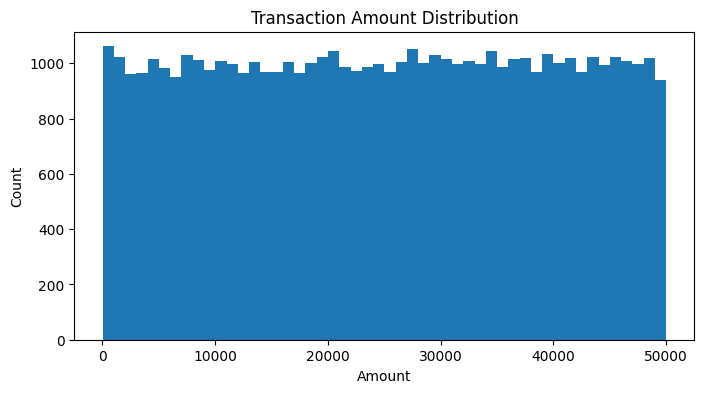

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.hist(df['amount'], bins=50)
plt.title("Transaction Amount Distribution")
plt.xlabel("Amount")
plt.ylabel("Count")
plt.show()


In [ ]:
txn_per_user = df.groupby('user_id')['transaction_id'].count()
txn_per_user.describe()
#Gives stastics of number of Transactions been done

,transaction_id
count,16696.000000
mean,2.994729
std,1.749231
min,1.000000
25%,2.000000
50%,3.000000
75%,4.000000
max,18.000000


In [ ]:
df['hour'] = df['transaction_time'].dt.hour


In [ ]:
df['hour'].value_counts().sort_index()


,count
hour,
9,45011
10,4989


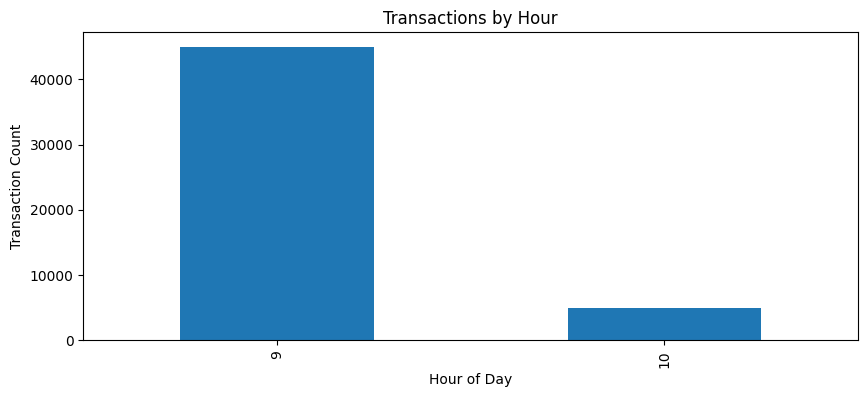

In [ ]:
df['hour'].value_counts().sort_index().plot(kind='bar', figsize=(10,4))
plt.title("Transactions by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Transaction Count")
plt.show()


In [ ]:
df['location_country'].value_counts().head(10)


,count
location_country,
India,40954
USA,5945
UK,3101


Feature Engineering

In [ ]:
df['is_midnight_txn'] = df['hour'].between(0, 4).astype(int)


In [ ]:
#checking if the current transaction country is different from their previous transaction country. If yes, mark it as a new-country transaction.
df['prev_country'] = df.groupby('user_id')['location_country'].shift(1)

df['is_new_country'] = (
    df['location_country'] != df['prev_country']
).astype(int)

df['is_new_country'] = df['is_new_country'].fillna(0)


In [ ]:
df['time_diff_sec'] = (
    df.groupby('user_id')['transaction_time']
    .diff()
    .dt.total_seconds()
    .fillna(0)
)


In [ ]:
df['txn_count_10min'] = (
    df.groupby('user_id')
    .rolling('10min', on='transaction_time')['transaction_id']
    .count()
    .reset_index(level=0, drop=True)
    .fillna(0)
)
#How many transactions did this user make in the last 10 minute

In [ ]:
df['amt_sum_10min'] = (
    df.groupby('user_id')
    .rolling('10min', on='transaction_time')['amount']
    .sum()
    .reset_index(level=0, drop=True)
    .fillna(0)
)


In [ ]:
df['hard_block'] = (
    (df['txn_count_10min'] >= 3) |
    (df['is_new_country'] == 1)
).astype(int)


In [ ]:
df['user_avg_amount'] = (
    df.groupby('user_id')['amount']
    .expanding()
    .mean()
    .shift()
    .reset_index(level=0, drop=True)
)

df['user_avg_amount'] = df['user_avg_amount'].fillna(df['amount'])
df['amount_vs_avg'] = df['amount'] / df['user_avg_amount']


In [ ]:
df['is_fraud'] = 0

df.loc[
    (df['txn_count_10min'] >= 3) |
    (df['is_new_country'] == 1),
    'is_fraud'
] = 1


Training and Testing

In [ ]:
FEATURES = [
    'amount',
    'amount_vs_avg',
    'time_diff_sec',
    'txn_count_10min',
    'amt_sum_10min',
    'is_midnight_txn',
    'is_new_country'
]


In [ ]:
X = df[FEATURES]
y = df['is_fraud']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [ ]:
X_train.shape, X_test.shape


((40000, 7), (10000, 7))

In [ ]:
xgb_fraud = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    eval_metric='logloss',
    random_state=42
)

xgb_fraud.fit(X_train, y_train)
df['risk_score'] = xgb_fraud.predict_proba(X)[:,1]


In [ ]:
df['risk_score'].describe()


,risk_score
count,50000.000000
mean,0.360080
std,0.479918
min,0.000039
25%,0.000039
50%,0.000039
75%,0.999931
max,0.999931


In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

iso_model = IsolationForest(
    n_estimators=300,
    contamination=0.02,
    random_state=42
)

iso_model.fit(X_scaled)
df['anomaly_score'] = -iso_model.decision_function(X_scaled)
ANOMALY_FLAG_THRESHOLD = df['anomaly_score'].quantile(0.98)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.12/dist-packages/sklearn/utils/extmath.py:1106: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.12/dist-packages/sklearn/utils/extmath.py:1126: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


In [ ]:
df['anomaly_score'].describe()


,anomaly_score
count,50000.000000
mean,-0.040716
std,0.014346
min,-0.058370
25%,-0.050427
50%,-0.044608
75%,-0.035783
max,0.090871


In [ ]:
# initialize
df['is_fraud'] = 0   # default legit

# BLOCK cases → fraud = 1
df.loc[
    (df['txn_count_10min'] >= 3) |
    (df['is_new_country'] == 1),
    'is_fraud'
] = 1

# FLAG cases → fraud = 1 (but lower confidence)
df.loc[
    (df['is_midnight_txn'] == 1) &
    (df['amount'] > df['amount'].quantile(0.95)),
    'is_fraud'
] = 1


In [ ]:
def hybrid_decision_verbose(row):
    reasons = []

    if row['txn_count_10min'] >= 3:
        reasons.append("High transaction velocity")

    if row['is_amount_spike'] == 1:
        reasons.append("Sudden large transaction compared to user history")

    if row['risk_score'] > 0.8:
        reasons.append("Matches known fraud pattern")

    if row['anomaly_score'] > df['anomaly_score'].quantile(0.99):
        reasons.append("Highly anomalous behavior")

    # Decision priority
    if "High transaction velocity" in reasons or row['risk_score'] > 0.8:
        action = "BLOCK"
    elif row['is_amount_spike'] == 1:
        action = "FLAG"
    elif row['anomaly_score'] > df['anomaly_score'].quantile(0.99):
        action = "FLAG"
    else:
        action = "ALLOW"

    return action, ", ".join(reasons)


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# predictions
y_pred = xgb_fraud.predict(X_test)
y_prob = xgb_fraud.predict_proba(X_test)[:,1]

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))


[[6399    0]
 [   0 3601]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6399
           1       1.00      1.00      1.00      3601

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000

ROC AUC: 1.0


In [ ]:
df.groupby('is_fraud')['anomaly_score'].describe()


,count,mean,std,min,25%,50%,75%,max
is_fraud,,,,,,,,
0,31996.0,-0.042651,0.015339,-0.058370,-0.052595,-0.048147,-0.037510,0.087911
1,18004.0,-0.037279,0.011617,-0.047597,-0.045296,-0.040583,-0.034039,0.090871


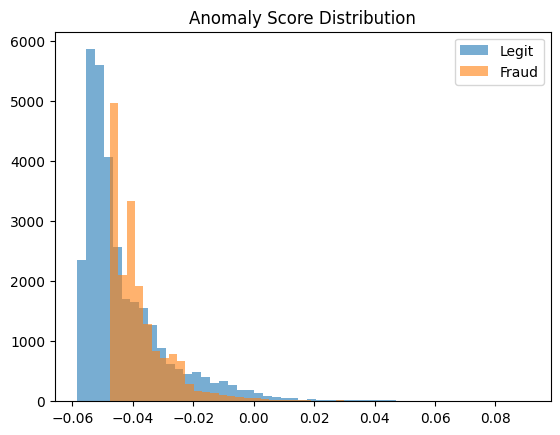

In [ ]:
import matplotlib.pyplot as plt

plt.hist(df[df['is_fraud']==0]['anomaly_score'], bins=50, alpha=0.6, label='Legit')
plt.hist(df[df['is_fraud']==1]['anomaly_score'], bins=50, alpha=0.6, label='Fraud')
plt.legend()
plt.title("Anomaly Score Distribution")
plt.show()


In [ ]:
new_txn_1 = {
    'transaction_id': 'TXN_NEW_1',
    'user_id': df['user_id'].iloc[0],
    'amount': 500,
    'location_country': df['location_country'].iloc[0],
    'transaction_time': df['transaction_time'].max() + pd.Timedelta(minutes=30)
}


In [ ]:
new_txn_2 = {
    'transaction_id': 'TXN_NEW_2',
    'user_id': df['user_id'].iloc[0],
    'amount': df['amount'].quantile(0.99),
    'location_country': 'Germany',
    'transaction_time': df['transaction_time'].max() + pd.Timedelta(minutes=1)
}


In [ ]:
new_txn_3 = {
    'transaction_id': 'TXN_NEW_3',
    'user_id': df['user_id'].iloc[0],
    'amount': df['amount'].quantile(0.99),   # very large amount
    'location_country': df['location_country'].iloc[0],
    'transaction_time': df['transaction_time'].max() + pd.Timedelta(hours=2)
}


In [ ]:
def build_features(new_txn, history_df):
    """
    Builds behavioral features for a new transaction
    using past transaction history of the same user.
    """

    user_hist = history_df[history_df['user_id'] == new_txn['user_id']]

    # -------- Amount behavior --------
    if len(user_hist) == 0:
        user_avg_amount = new_txn['amount']
    else:
        user_avg_amount = user_hist['amount'].mean()

    amount_vs_avg = new_txn['amount'] / max(user_avg_amount, 1)
    amount_vs_avg = min(amount_vs_avg, 20)

    # -------- Time-based features --------
    if len(user_hist) < 2:
        time_diff_sec = 0
        txn_count_10min = 1
        amt_sum_10min = new_txn['amount']
        is_new_country = 0   # 🚨 IMPORTANT CHANGE
    else:
        last_txn = user_hist.iloc[-1]

        time_diff_sec = (
            new_txn['transaction_time'] - last_txn['transaction_time']
        ).total_seconds()

        window = user_hist[
            user_hist['transaction_time'] >=
            new_txn['transaction_time'] - pd.Timedelta(minutes=10)
        ]

        txn_count_10min = len(window) + 1
        amt_sum_10min = window['amount'].sum() + new_txn['amount']

        # new-country logic
        if last_txn['location_country'] == 'UNKNOWN':
            is_new_country = 0
        else:
            is_new_country = int(
                new_txn['location_country'] != last_txn['location_country']
            )

    # -------- Contextual features --------
    is_midnight_txn = int(new_txn['transaction_time'].hour <= 4)

    # -------- Final feature row --------
    X_new = pd.DataFrame([{
        'amount': new_txn['amount'],
        'amount_vs_avg': amount_vs_avg,
        'time_diff_sec': time_diff_sec,
        'txn_count_10min': txn_count_10min,
        'amt_sum_10min': amt_sum_10min,
        'is_midnight_txn': is_midnight_txn,
        'is_new_country': is_new_country
    }])

    return X_new


In [ ]:
test = build_features(new_txn_1, df)
test.columns.tolist()


['amount',
 'amount_vs_avg',
 'time_diff_sec',
 'txn_count_10min',
 'amt_sum_10min',
 'is_midnight_txn',
 'is_new_country']

In [ ]:
def test_new_transaction_verbose(new_txn, history_df):
    # Build features
    X_new = build_features(new_txn, history_df)

    # Scores
    risk_score = xgb_fraud.predict_proba(X_new)[0][1]
    X_scaled = scaler.transform(X_new)
    anomaly_score = -iso_model.decision_function(X_scaled)[0]

    reasons = []

    # Rule checks
    if X_new['txn_count_10min'].iloc[0] >= 3:
        reasons.append("High transaction velocity (≥3 txns in 10 min)")

    if X_new['amount_vs_avg'].iloc[0] >= 3:
        reasons.append("Sudden large amount compared to user history")

    if X_new['is_new_country'].iloc[0] == 1:
        reasons.append("Transaction from a new country")

    if X_new['is_midnight_txn'].iloc[0] == 1:
        reasons.append("Transaction during unusual hours")

    if risk_score > 0.8:
        reasons.append("Matches known fraud patterns (high risk score)")

    if anomaly_score > ANOMALY_FLAG_THRESHOLD:
        reasons.append("Unusual behavior detected (anomaly)")

    # Decision logic (priority order)
    if X_new['txn_count_10min'].iloc[0] >= 3 or risk_score > 0.8:
        action = "BLOCK"
    elif anomaly_score > ANOMALY_FLAG_THRESHOLD or X_new['amount_vs_avg'].iloc[0] >= 3:
        action = "FLAG"
    else:
        action = "ALLOW"

    # Confidence bucket
    if action == "BLOCK":
        confidence = "HIGH"
    elif action == "FLAG":
        confidence = "MEDIUM"
    else:
        confidence = "LOW"

    return {
        "user_id": new_txn['user_id'],
        "transaction_id": new_txn['transaction_id'],
        "amount": new_txn['amount'],
        "location_country": new_txn['location_country'],
        "transaction_time": new_txn['transaction_time'],
        "risk_score": float(risk_score),
        "anomaly_score": float(anomaly_score),
        "decision_confidence": confidence,
        "action": action,
        "reason": ", ".join(reasons) if reasons else "Normal transaction behavior"
    }


In [ ]:
print(test_new_transaction_verbose(new_txn_1, df))
print(test_new_transaction_verbose(new_txn_2, df))
print(test_new_transaction_verbose(new_txn_3, df))

{'user_id': 'USR_10007', 'transaction_id': 'TXN_NEW_1', 'amount': 500, 'location_country': 'India', 'transaction_time': Timestamp('2025-12-18 10:35:49.626114'), 'risk_score': 3.893333996529691e-05, 'anomaly_score': -0.03644599123657344, 'decision_confidence': 'LOW', 'action': 'ALLOW', 'reason': 'Normal transaction behavior'}
{'user_id': 'USR_10007', 'transaction_id': 'TXN_NEW_2', 'amount': np.float64(49441.6384), 'location_country': 'Germany', 'transaction_time': Timestamp('2025-12-18 10:06:49.626114'), 'risk_score': 0.9999308586120605, 'anomaly_score': -0.01666682951909937, 'decision_confidence': 'HIGH', 'action': 'BLOCK', 'reason': 'Transaction from a new country, Matches known fraud patterns (high risk score)'}
{'user_id': 'USR_10007', 'transaction_id': 'TXN_NEW_3', 'amount': np.float64(49441.6384), 'location_country': 'India', 'transaction_time': Timestamp('2025-12-18 12:05:49.626114'), 'risk_score': 3.893333996529691e-05, 'anomaly_score': -0.03554057420466589, 'decision_confidence

In [ ]:
new_txn_user1 = {
    'transaction_id': 'TXN_U1_1',
    'user_id': 'USR_10001',
    'amount': 800,
    'location_country': 'India',
    'transaction_time': df['transaction_time'].max() + pd.Timedelta(minutes=20)
}

print(test_new_transaction_verbose(new_txn_user1, df))


{'user_id': 'USR_10001', 'transaction_id': 'TXN_U1_1', 'amount': 800, 'location_country': 'India', 'transaction_time': Timestamp('2025-12-18 10:25:49.626114'), 'risk_score': 3.893333996529691e-05, 'anomaly_score': -0.03562425005860281, 'decision_confidence': 'LOW', 'action': 'ALLOW', 'reason': 'Normal transaction behavior'}


In [ ]:
new_txn_user2 = {
    'transaction_id': 'TXN_U2_1',
    'user_id': 'USR_10002',
    'amount': df['amount'].quantile(0.99),
    'location_country': 'Germany',
    'transaction_time': df['transaction_time'].max() + pd.Timedelta(minutes=5)
}

print(test_new_transaction_verbose(new_txn_user2, df))


{'user_id': 'USR_10002', 'transaction_id': 'TXN_U2_1', 'amount': np.float64(49441.6384), 'location_country': 'Germany', 'transaction_time': Timestamp('2025-12-18 10:10:49.626114'), 'risk_score': 3.893333996529691e-05, 'anomaly_score': -0.03096832392877502, 'decision_confidence': 'LOW', 'action': 'ALLOW', 'reason': 'Normal transaction behavior'}


In [ ]:
user3 = df['user_id'].unique()[2]

new_txn_user3 = {
    'transaction_id': 'TXN_U3_1',
    'user_id': user3,
    'amount': df[df['user_id']==user3]['amount'].mean() * 4,
    'location_country': df[df['user_id']==user3]['location_country'].iloc[0],
    'transaction_time': df['transaction_time'].max() + pd.Timedelta(hours=3)
}

print(test_new_transaction_verbose(new_txn_user3, df))


{'user_id': 'USR_10020', 'transaction_id': 'TXN_U3_1', 'amount': np.float64(90399.30666666666), 'location_country': 'India', 'transaction_time': Timestamp('2025-12-18 13:05:49.626114'), 'risk_score': 3.893333996529691e-05, 'anomaly_score': 0.017215970229313315, 'decision_confidence': 'MEDIUM', 'action': 'FLAG', 'reason': 'Sudden large amount compared to user history, Unusual behavior detected (anomaly)'}


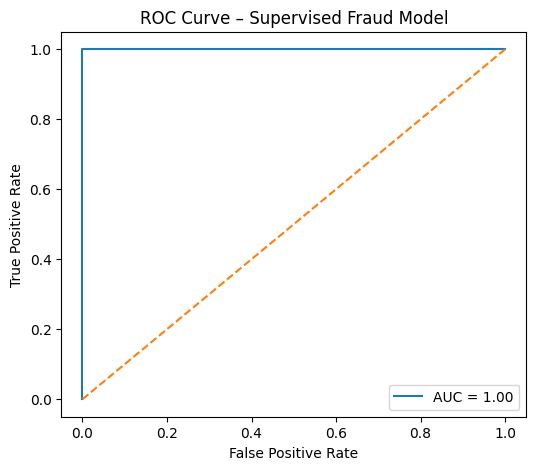

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_prob = xgb_fraud.predict_proba(X_test)[:,1]

fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Supervised Fraud Model")
plt.legend()
plt.show()


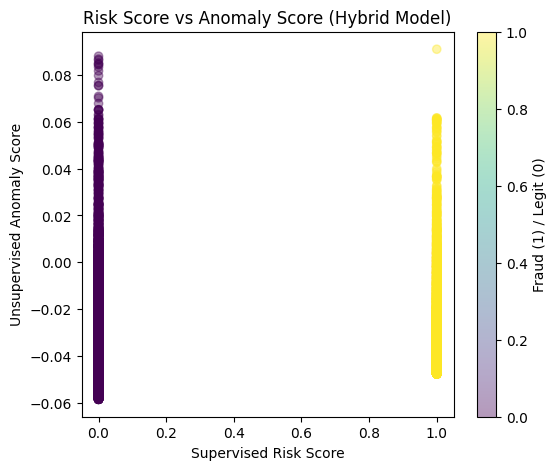

In [ ]:
plt.figure(figsize=(6,5))
plt.scatter(
    df['risk_score'],
    df['anomaly_score'],
    c=df['is_fraud'],
    alpha=0.4
)
plt.xlabel("Supervised Risk Score")
plt.ylabel("Unsupervised Anomaly Score")
plt.title("Risk Score vs Anomaly Score (Hybrid Model)")
plt.colorbar(label="Fraud (1) / Legit (0)")
plt.show()


In [ ]:
def apply_final_action(row):
    if row['txn_count_10min'] >= 3 or row['risk_score'] > 0.8:
        return 'BLOCK'
    elif row['anomaly_score'] > ANOMALY_FLAG_THRESHOLD or row['amount_vs_avg'] >= 3:
        return 'FLAG'
    else:
        return 'ALLOW'

df['final_action'] = df.apply(apply_final_action, axis=1)


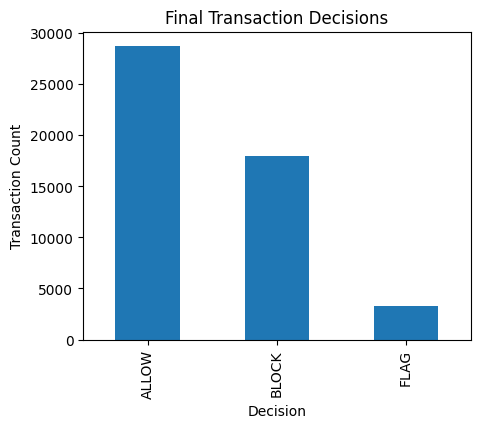

In [ ]:
df['final_action'].value_counts().plot(kind='bar', figsize=(5,4))
plt.title("Final Transaction Decisions")
plt.xlabel("Decision")
plt.ylabel("Transaction Count")
plt.show()


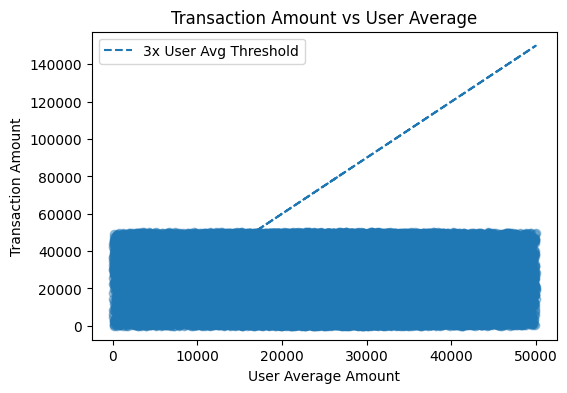

In [ ]:
plt.figure(figsize=(6,4))
plt.scatter(df['user_avg_amount'], df['amount'], alpha=0.4)
plt.plot(
    df['user_avg_amount'],
    df['user_avg_amount']*3,
    linestyle='--',
    label='3x User Avg Threshold'
)
plt.xlabel("User Average Amount")
plt.ylabel("Transaction Amount")
plt.title("Transaction Amount vs User Average")
plt.legend()
plt.show()


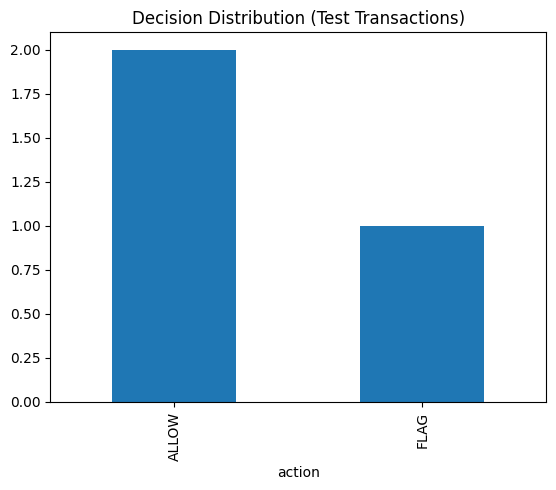

In [ ]:
results = [
    test_new_transaction_verbose(new_txn_user1, df),
    test_new_transaction_verbose(new_txn_user2, df),
    test_new_transaction_verbose(new_txn_user3, df)
]

results_df = pd.DataFrame(results)

results_df['action'].value_counts().plot(kind='bar')
plt.title("Decision Distribution (Test Transactions)")
plt.show()


Exporting model

In [ ]:
import joblib

joblib.dump(xgb_fraud, "/content/xgb_fraud.pkl")
joblib.dump(iso_model, "/content/iso_model.pkl")
joblib.dump(scaler, "/content/scaler.pkl")

['/content/scaler.pkl']